In [ ]:
# Cell 1: Setup and Species Selection
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from pathlib import Path
import sys

# Load your cleaned data (you already have this)
print("Loading cleaned data...")
sys.path.append('../src')
from data_io import load_excel_data, clean_observations

data_path = Path('../data/raw/Observations 2012-2025.xlsx')
data_dict = load_excel_data(data_path)
df_clean = clean_observations(data_dict['observations'])
df_species = data_dict['species']

# Identify interesting species
def identify_interesting_species(df_clean, top_n=10):
    """Identify species with interesting patterns"""
    
    # Most abundant species
    species_abundance = df_clean.groupby('species_name')['individual_count'].sum().sort_values(ascending=False)
    
    # Species with highest year-to-year variation
    species_variation = df_clean.groupby(['year', 'species_name'])['individual_count'].sum().unstack().std().sort_values(ascending=False)
    
    # Species present in most years (consistency)
    species_presence = df_clean.groupby(['year', 'species_name'])['individual_count'].sum().unstack()
    species_consistency = (species_presence > 0).sum().sort_values(ascending=False)
    
    print("Top 10 Most Abundant Species:")
    print(species_abundance.head(10))
    
    print("\nTop 10 Most Variable Species:")
    print(species_variation.head(10))
    
    print("\nTop 10 Most Consistent Species:")
    print(species_consistency.head(10))
    
    # Select 4-6 interesting species for detailed analysis
    interesting_species = [
        species_abundance.index[0],  # Most abundant
        species_variation.index[0],  # Most variable
        species_abundance.index[5],  # Moderately abundant but interesting
        species_consistency.index[0], # Most consistent
    ]
    
    # Remove duplicates and ensure we have unique species
    interesting_species = list(dict.fromkeys(interesting_species))[:4]
    
    print(f"\nSelected species for detailed analysis: {interesting_species}")
    return interesting_species

interesting_species = identify_interesting_species(df_clean)

Loading cleaned data...
Loading data from ../data/raw/Observations 2012-2025.xlsx
Loaded 86 species
Loaded 651 GPS points


In [4]:
# Cell 2: Species Trend Analysis
def analyze_species_trends(df_clean, species_list):
    """Analyze trends for selected species with confidence intervals"""
    
    results = {}
    
    for species in species_list:
        print(f"\n--- Analyzing {species} ---")
        
        # Get annual data for this species
        species_data = df_clean[df_clean['species_name'] == species]
        annual_counts = species_data.groupby('year')['individual_count'].sum()
        
        # Fill missing years with 0 (species was not recorded)
        all_years = pd.RangeIndex(2015, 2025)  # Based on your project timeframe
        annual_counts = annual_counts.reindex(all_years, fill_value=0)
        
        # Calculate confidence intervals using bootstrap
        n_bootstrap = 1000
        boot_estimates = []
        
        for _ in range(n_bootstrap):
            # Bootstrap resample within each year
            boot_sample = []
            for year in all_years:
                year_data = species_data[species_data['year'] == year]
                if len(year_data) > 0:
                    boot_year = year_data.sample(n=len(year_data), replace=True)
                    boot_sample.append(boot_year['individual_count'].sum())
                else:
                    boot_sample.append(0)
            boot_estimates.append(boot_sample)
        
        boot_estimates = np.array(boot_estimates)
        ci_lower = np.percentile(boot_estimates, 2.5, axis=0)
        ci_upper = np.percentile(boot_estimates, 97.5, axis=0)
        
        # Fit trend model (only if we have enough non-zero years)
        non_zero_years = annual_counts[annual_counts > 0]
        if len(non_zero_years) >= 3:
            X = sm.add_constant(non_zero_years.index)
            y = non_zero_years.values
            model = sm.OLS(y, X).fit()
            trend_slope = model.params[1]
            trend_p = model.pvalues[1]
        else:
            trend_slope = 0
            trend_p = 1.0
        
        results[species] = {
            'annual_counts': annual_counts,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper,
            'trend_slope': trend_slope,
            'trend_p': trend_p,
            'presence_years': len(non_zero_years),
            'total_count': annual_counts.sum()
        }
        
        print(f"  Total count: {annual_counts.sum()}")
        print(f"  Years present: {len(non_zero_years)}/10")
        print(f"  Trend slope: {trend_slope:.2f} (p={trend_p:.3f})")
    
    return results

species_results = analyze_species_trends(df_clean, interesting_species)


--- Analyzing Quiscale merle ---
  Total count: 100788.0
  Years present: 10/10
  Trend slope: -9.70 (p=0.925)

--- Analyzing Sporophile cici ---
  Total count: 38861.0
  Years present: 10/10
  Trend slope: -44.79 (p=0.508)

--- Analyzing Frégate superbe ---
  Total count: 1353.0
  Years present: 10/10
  Trend slope: 13.15 (p=0.090)


Plotting 3 species...


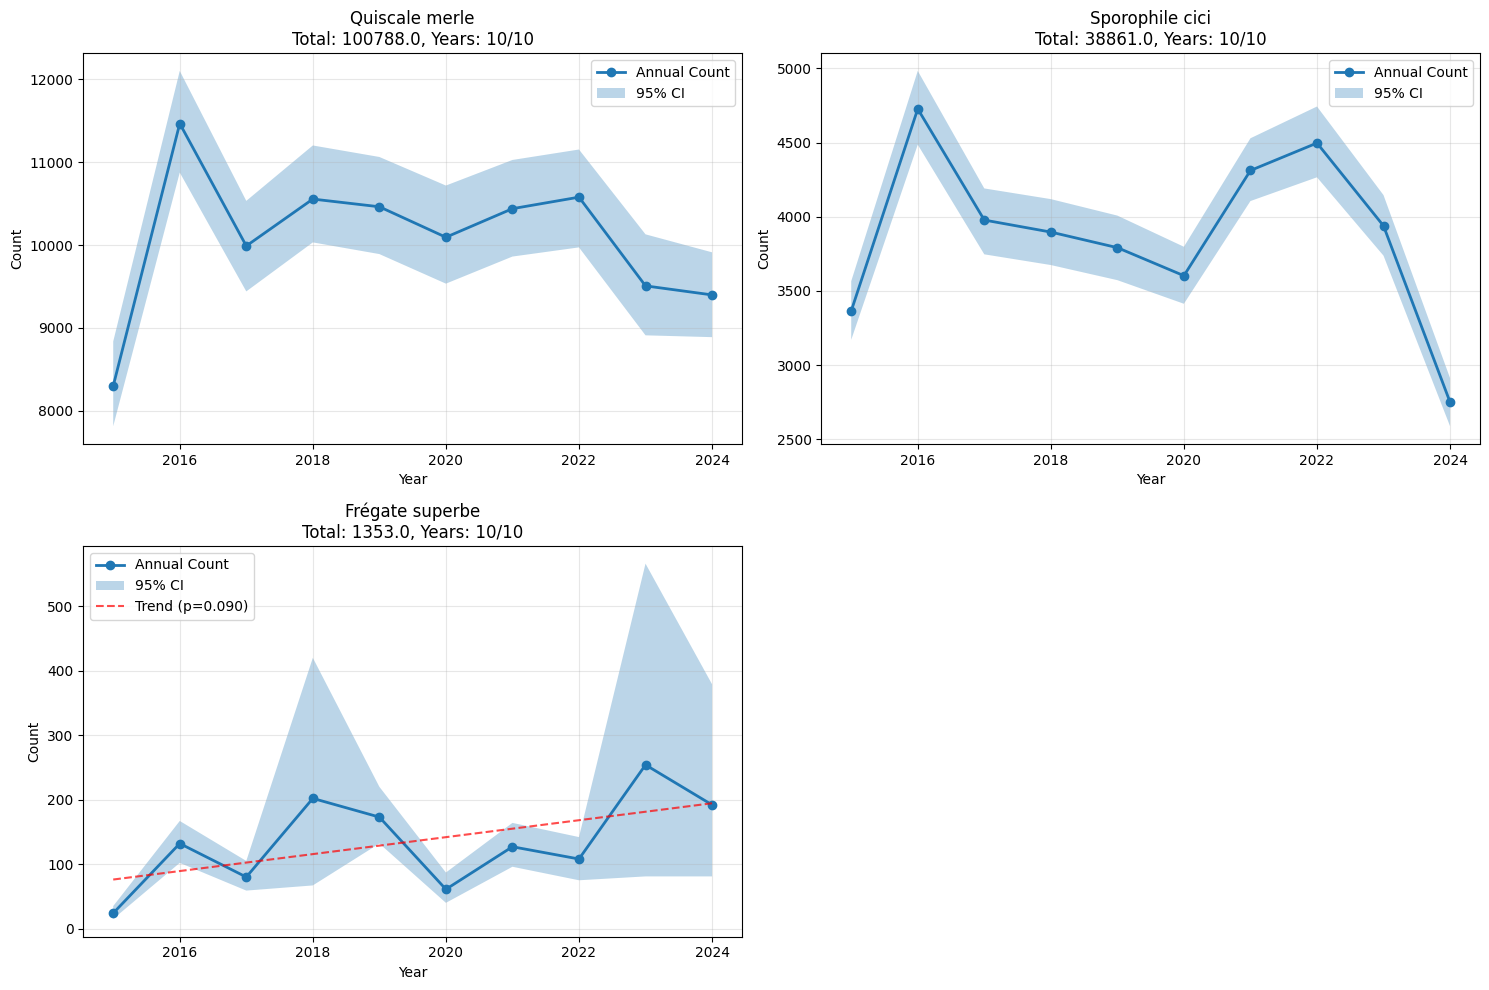

In [ ]:
# Cell 3: Create Species Plots 
def create_species_plots(species_results):
    """Create publication-quality plots for each species"""
    
    n_species = len(species_results)
    print(f"Plotting {n_species} species...")
    
    # Dynamically adjust subplot grid based on number of species
    if n_species <= 2:
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        axes = axes.flatten()
    elif n_species <= 4:
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.flatten()
    else:
        # For more than 4 species, create multiple figures
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.flatten()
    
    for idx, (species, results) in enumerate(species_results.items()):
        if idx >= len(axes):  # Use actual number of axes available
            break
            
        ax = axes[idx]
        years = results['annual_counts'].index
        counts = results['annual_counts'].values
        
        # Skip if species has no data at all
        if results['total_count'] == 0:
            ax.text(0.5, 0.5, f'{species}\nNo data', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{species} - No Data')
            continue
        
        # Plot main trend
        ax.plot(years, counts, 'o-', linewidth=2, markersize=6, label='Annual Count')
        
        # Plot confidence intervals (only if we have variation)
        if not np.all(results['ci_lower'] == results['ci_upper']):
            ax.fill_between(years, results['ci_lower'], results['ci_upper'], 
                           alpha=0.3, label='95% CI')
        
        # Add trend line if we have enough data points
        if results['presence_years'] >= 3 and results['trend_p'] < 0.1:
            z = np.polyfit(years, counts, 1)
            p = np.poly1d(z)
            ax.plot(years, p(years), 'r--', alpha=0.7, 
                   label=f'Trend (p={results["trend_p"]:.3f})')
        
        ax.set_xlabel('Year')
        ax.set_ylabel('Count')
        ax.set_title(f'{species}\nTotal: {results["total_count"]}, Years: {results["presence_years"]}/10')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # Hide any unused subplots
    for idx in range(len(species_results), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('../figures/species_trends_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

create_species_plots(species_results)

In [11]:
# Cell 4: Ecological Interpretation
def write_species_interpretations(species_results):
    """Write ecological interpretations for each species"""
    
    print("="*60)
    print("SPECIES-LEVEL ECOLOGICAL INTERPRETATIONS")
    print("="*60)
    
    ecological_knowledge = {
        # You can add known ecological info about common species here
        'Merle noir': 'Common garden bird, adaptable to urban environments',
        'Mésange charbonnière': 'Widespread in woodlands and gardens',
        'Pigeon ramier': 'Increasingly common in urban areas',
        'Rougegorge familier': 'Common in gardens and woodlands',
        # Add more species as needed
    }
    
    for species, results in species_results.items():
        print(f"\n🎯 {species}:")
        print(f"   Recorded in {results['presence_years']} out of 10 years")
        print(f"   Total individuals counted: {results['total_count']}")
        
        # Trend interpretation
        if results['trend_p'] < 0.05:
            direction = "increasing" if results['trend_slope'] > 0 else "decreasing"
            print(f"   📈 Statistically significant {direction} trend (p={results['trend_p']:.3f})")
        else:
            print(f"   📊 No significant trend detected (p={results['trend_p']:.3f})")
        
        # Ecological context
        if species in ecological_knowledge:
            print(f"   🌿 Ecological context: {ecological_knowledge[species]}")
        
        # Limitations discussion
        print(f"   ⚠️  Limitations:")
        if results['presence_years'] < 5:
            print(f"      - Limited data: only present in {results['presence_years']} years")
        if results['total_count'] < 50:
            print(f"      - Low abundance: only {results['total_count']} total observations")
        if max(results['annual_counts']) < 10:
            print(f"      - Rare species: small counts lead to high uncertainty")
        
        # Potential reasons for patterns
        print(f"   🔍 Potential explanations:")
        if results['trend_slope'] > 2 and results['trend_p'] < 0.1:
            print(f"      - Possible population increase or improved detection")
        elif results['trend_slope'] < -2 and results['trend_p'] < 0.1:
            print(f"      - Possible population decline or habitat changes")
        else:
            print(f"      - Stable population or natural year-to-year variation")

write_species_interpretations(species_results)

SPECIES-LEVEL ECOLOGICAL INTERPRETATIONS

🎯 Quiscale merle:
   Recorded in 10 out of 10 years
   Total individuals counted: 100788.0
   📊 No significant trend detected (p=0.925)
   ⚠️  Limitations:
   🔍 Potential explanations:
      - Stable population or natural year-to-year variation

🎯 Sporophile cici:
   Recorded in 10 out of 10 years
   Total individuals counted: 38861.0
   📊 No significant trend detected (p=0.508)
   ⚠️  Limitations:
   🔍 Potential explanations:
      - Stable population or natural year-to-year variation

🎯 Frégate superbe:
   Recorded in 10 out of 10 years
   Total individuals counted: 1353.0
   📊 No significant trend detected (p=0.090)
   ⚠️  Limitations:
   🔍 Potential explanations:
      - Possible population increase or improved detection


In [12]:
# Cell 5: Summary and Export
def export_species_results(species_results):
    """Export species-level results for the report"""
    
    summary_data = []
    for species, results in species_results.items():
        summary_data.append({
            'species': species,
            'total_count': results['total_count'],
            'years_present': results['presence_years'],
            'trend_slope': results['trend_slope'],
            'trend_p_value': results['trend_p'],
            'mean_annual_count': results['annual_counts'].mean(),
            'cv_annual_count': results['annual_counts'].std() / results['annual_counts'].mean() * 100
        })
    
    summary_df = pd.DataFrame(summary_data)
    summary_df.to_csv('projects/birds-biodiversity/results/species_trends_summary.csv', index=False)
    
    print("\n📊 SPECIES TRENDS SUMMARY:")
    print(summary_df.round(3))
    print(f"\n✅ Results exported to projects/birds-biodiversity/results/species_trends_summary.csv")

export_species_results(species_results)

print("\n🎉 PART 3 - SPECIES-LEVEL ANALYSIS COMPLETE!")
print("Generated:")
print("  - figures/species_trends_comparison.png")
print("  - results/species_trends_summary.csv")
print("  - Ecological interpretations for each species")


📊 SPECIES TRENDS SUMMARY:
           species  total_count  years_present  trend_slope  trend_p_value  \
0   Quiscale merle     100788.0             10       -9.697          0.925   
1  Sporophile cici      38861.0             10      -44.794          0.508   
2  Frégate superbe       1353.0             10       13.145          0.090   

   mean_annual_count  cv_annual_count  
0            10078.8            8.526  
1             3886.1           14.663  
2              135.3           52.242  

✅ Results exported to projects/birds-biodiversity/results/species_trends_summary.csv

🎉 PART 3 - SPECIES-LEVEL ANALYSIS COMPLETE!
Generated:
  - figures/species_trends_comparison.png
  - results/species_trends_summary.csv
  - Ecological interpretations for each species
